# Summary


This notebook show how to use utils functions to access LLD and Ve data.  
We then present a use case to generate a report comparing LLD and API data.  


**Note:** 
 - the download of the report should take around 11min
 - to disable logs:
    ```
    import logging
    logging.getLogger("py4j").setLevel(logging.ERROR)
    logging.getLogger("analytics_utils").setLevel(logging.INFO)
    ```

In [2]:
from analytics_utils.spark_utils import add_pyspark_path
import logging
logging.getLogger("analytics_utils").setLevel(logging.INFO)

In [3]:
import os
spark_home = '/usr/hdp/current/spark-client/'
add_pyspark_path(spark_home)
from pyspark import SparkContext
from pyspark.sql import HiveContext


import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.types import *

# Note: important to stop logging on server side of jupyter
logging.getLogger("py4j").setLevel(logging.ERROR)


max_executors = 12

NOTEBOOK_NAME = "Analytics utils"

def init_spark():
    # spark submit
    os.environ['PYSPARK_SUBMIT_ARGS'] = \
    '--verbose ' \
    '--jars /usr/hdp/current/hadoop-client/hadoop-azure.jar,/usr/hdp/current/hadoop-client/lib/azure-storage-2.2.0.jar ' \
    '--master yarn ' \
    '--deploy-mode client ' \
    '--driver-cores 2 --driver-memory 8g ' \
    '--executor-cores 1 --executor-memory 7g ' \
    '--conf spark.dynamicAllocation.maxExecutors={max_executors} ' \
    '--conf spark.shuffle.service.enabled=true ' \
    '--conf spark.dynamicAllocation.enabled=true ' \
    '--conf spark.sql.parquet.compression.codec=snappy ' \
    'pyspark-shell'.format(max_executors=max_executors)

    # spark context
    sc = SparkContext(appName=NOTEBOOK_NAME, sparkHome=spark_home)
    sc.setLogLevel('WARN')
    
    # sql context
    sqlContext = HiveContext(sparkContext=sc)
    return sc, sqlContext

try:
    sc, sqlContext = init_spark()
except ValueError:
    sc.stop()
    sc, sqlContext = init_spark()

# LLD

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
from analytics_utils.data_feeds import *
import analytics_utils.reports as reports

**Let's look at the available data: **

In [8]:
print('Available LLD feeds: %s' % [x.name for x in Feeds])
print('Available VeData feeds: %s' % [x.name for x in VeData])

Available LLD feeds: ['pixel', 'segment', 'standard']
Available VeData feeds: ['category', 'page']


**We only want the standard feed**

In [9]:
standard_feed = DataFeeds.get_feed_parquet(sqlContext, Feeds.standard, from_date="2016-07-10", to_date=None)

**Note**: this is equivalent to
```
standard_feed = DataFeeds.get_feed_parquet(sqlContext, Feeds.standard)
standard_feed = standard_feed.filter(VeFuncs.filter_date(from_date="2016-07-01"))
```

In [10]:
standard_feed.printSchema()

root
 |-- auction_id_64: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- user_tz_offset: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- media_type: integer (nullable = true)
 |-- fold_position: integer (nullable = true)
 |-- event_type: string (nullable = true)
 |-- imp_type: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- media_cost_dollars_cpm: double (nullable = true)
 |-- revenue_type: integer (nullable = true)
 |-- buyer_spend: double (nullable = true)
 |-- buyer_bid: double (nullable = true)
 |-- ecp: double (nullable = true)
 |-- eap: double (nullable = true)
 |-- is_imp: integer (nullable = true)
 |-- is_learn: integer (nullable = true)
 |-- predict_type_rev: integer (nullable = true)
 |-- othuser_id_64: long (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- ip_address_trunc: string (nullable = true)
 |-- geo_country: string (nullable = true)
 |-- geo_r

**Let's count the number of lines per day**

In [11]:
line_count_df = DataFeeds.count_lines(standard_feed, by="D")

2016-07-22 09:17:25 INFO [count_lines] 0.90900957 min


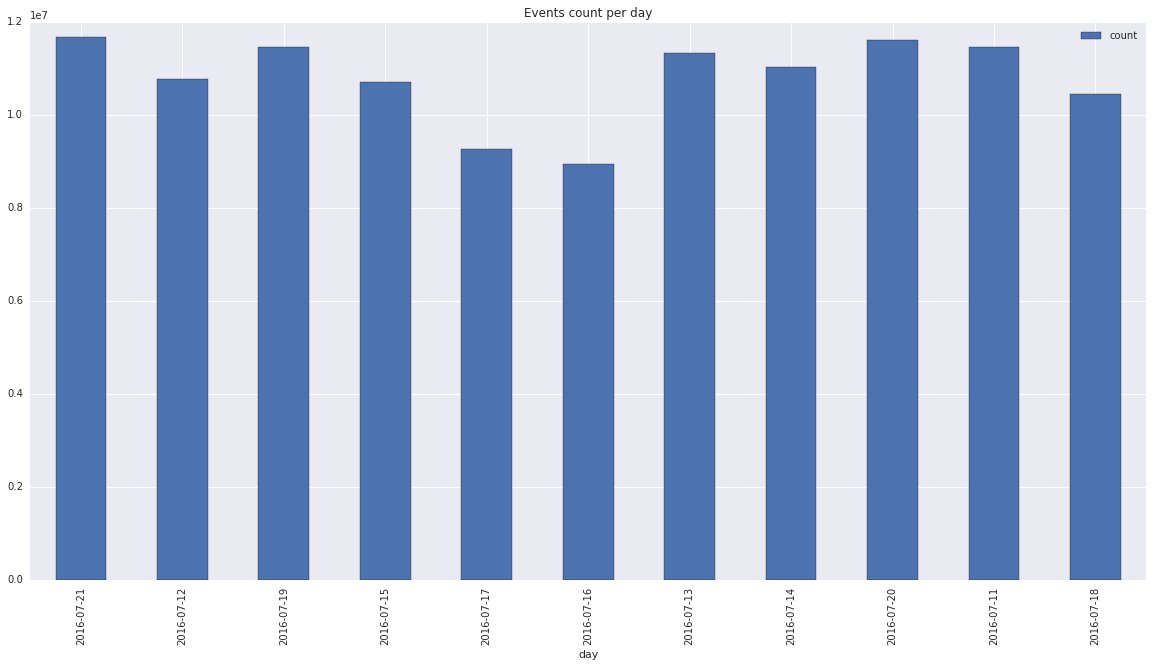

In [13]:
line_count_df.set_index('day').plot.bar(title="Events count per day", figsize=(20, 10))

**Now we want the converted users for July**

In [6]:
standard_feed = DataFeeds.get_feed_parquet(sqlContext, Feeds.standard, from_date="2016-07-01", to_date=None)


In [7]:
converted_users_df = DataFeeds.get_converted_users(standard_feed)

2016-07-22 09:50:24 INFO [get_converted_user_ids] 2.35351640 min
2016-07-22 09:55:48 INFO [get_converted_users] 7.75548985 min


In [12]:
converted_users_df = converted_users_df.cache()

In [19]:
nb_users = converted_users_df.select(converted_users_df.othuser_id_64).distinct().count()
print('%d converted users for July' % nb_users)

277927 converted users for July


**Let get the session duration for converted users in July**

In [6]:
from analytics_utils.ve_funcs import duration

In [7]:
standard_feed = DataFeeds.get_feed_parquet(sqlContext, Feeds.standard, from_date="2016-07-01", to_date=None)


In [14]:
converted_users_df = DataFeeds.get_converted_users(standard_feed)
auctions_duration = (converted_users_df.groupBy("othuser_id_64", "auction_id_64")
                                       .agg(duration.alias('duration'))
                     )

2016-07-25 14:34:16 INFO [get_converted_user_ids] 2.59941430 min
2016-07-25 14:40:25 INFO [get_converted_users] 8.75094335 min


In [15]:
users_avg_df = (auctions_duration.groupby('othuser_id_64')
                                 .agg(F.avg('duration').alias('avg_duration'))
                                 .toPandas()
                )

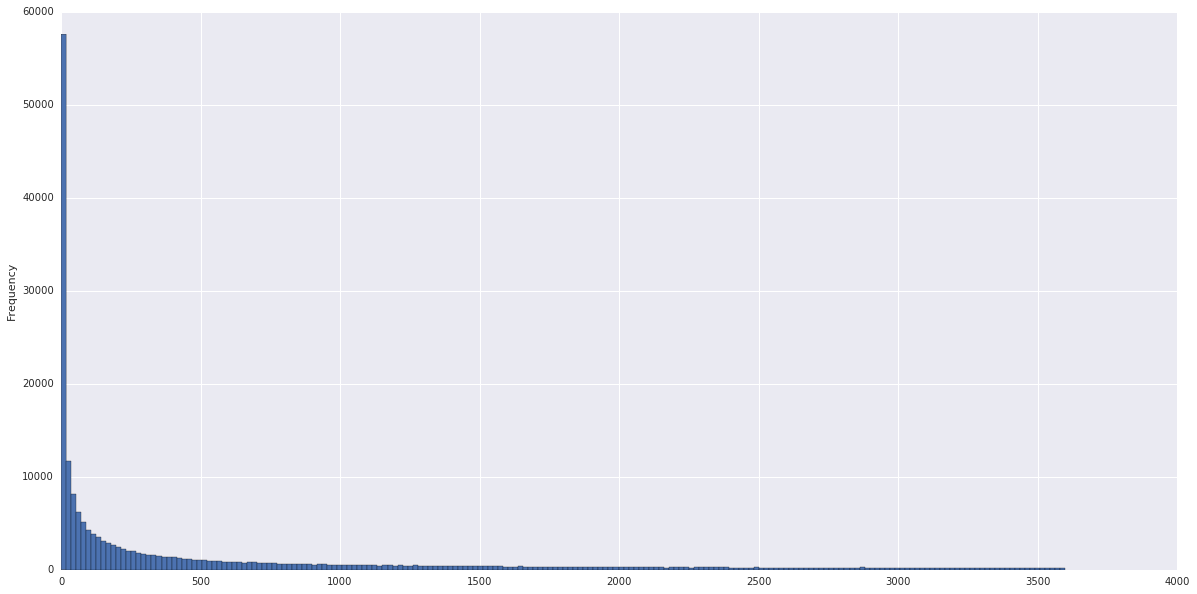

In [25]:
users_avg_df.avg_duration[users_avg_df.avg_duration < 60 * 60 * 1].plot.hist(bins=200, figsize=(20, 10))

# Example

### Let's rewrite the code to generate the report df

To run this example, please download a report following this [notebook](https://github.com/ve-interactive/AppNexus-API/blob/master/examples/AppNexus%20ReportsAPI.ipynb): 

**1. Getting data downloaded from the API**

In [33]:
report_path = "./reports/network_analytics_2016-07-22.csv"

In [34]:
df = pd.read_csv(report_path, sep=',', parse_dates=['hour'], index_col='hour')
from_date, to_date = df.index.min(), df.index.max()
df = df[str(from_date): str(to_date)]

**2. Formatting the API data**

In [35]:
df.head()

,insertion_order_id,line_item_id,campaign_id,advertiser_id,pixel_id,imps,imps_viewed,clicks,cost,cpm,cpm_including_fees,revenue,revenue_including_fees,total_convs,geo_country
hour,,,,,,,,,,,,,,,
2016-07-17 18:00:00,0,1744754,7125266,458344,0,2,0,0,0.001518,0.759000,0.759000,0.001518,0.001518,0,JO
2016-07-07 10:00:00,0,1496713,10664596,390226,0,1,1,0,0.001860,1.860000,1.860000,0.001860,0.001860,0,CH
2016-07-20 02:00:00,0,2902554,12819963,964325,0,1,0,0,0.000190,0.190000,0.190000,0.000190,0.000190,0,MY
2016-06-24 17:00:00,0,2694701,12003821,821925,0,4,0,0,0.013026,3.256500,3.256500,0.013026,0.013026,0,GB
2016-07-12 21:00:00,349299,3150186,13609046,1074914,0,24,6,0,0.021143,0.880958,0.930958,0.040625,0.040625,0,ES


In [36]:
df_agg = df.groupby([pd.TimeGrouper('D'), 'advertiser_id']).agg({
    'imps': {'nb_imps': 'sum'},
    'cpm': {'cpm': 'sum'},
    'revenue': {'revenue': 'sum'},
    'imps_viewed': {'nb_viewed': 'sum'},
    'clicks': {'nb_clicks': 'sum'},
    'total_convs': {'nb_convs': 'sum'}
})
df_agg.columns = df_agg.columns.droplevel(0)
df_agg = df_agg.reset_index().rename(columns={'hour': 'date'})
df_agg.head()

,date,advertiser_id,nb_imps,nb_viewed,cpm,revenue,nb_convs,nb_clicks
0,2016-06-22,0,79,6,0.256675,0.001670,0,0
1,2016-06-22,21149,83357,28620,1625.754892,395.120526,6,60
2,2016-06-22,60690,1985,853,239.245048,9.805646,13,1
3,2016-06-22,63864,14940,5704,3262.663625,19.493155,106,7
4,2016-06-22,66895,6,1,28.345000,0.041648,0,0


**3. Getting the corresponding range of time in LLD**

In [37]:
standard_df = DataFeeds.get_feed_parquet(sqlContext, Feeds.standard, from_date, to_date)
standard_df = reports.agg_standard_feed(standard_df)

2016-07-22 11:32:49 INFO [agg_standard_feed] 5.47264541 min


**4. Format LLD Data**

In [38]:
standard_df = standard_df[standard_df.advertiser_id.notnull()]
standard_df.advertiser_id = standard_df.advertiser_id.astype('int64')
standard_df.date = pd.to_datetime(standard_df.date)

**5. Aggregating the results**

In [39]:
full_df = pd.merge(df_agg, standard_df, on=['date', 'advertiser_id'],
                   suffixes=('_api', ''), how='outer').fillna(0)
full_df.head()

,date,advertiser_id,nb_imps_api,nb_viewed_api,cpm_api,revenue_api,nb_convs_api,nb_clicks_api,nb_convs,nb_imps,nb_clicks,nb_viewed,revenue,cpm
0,2016-06-22,0,79,6,0.256675,0.001670,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-06-22,21149,83357,28620,1625.754892,395.120526,6,60,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-06-22,60690,1985,853,239.245048,9.805646,13,1,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-06-22,63864,14940,5704,3262.663625,19.493155,106,7,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-06-22,66895,6,1,28.345000,0.041648,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
to_compare = ['nb_convs', 'nb_imps', 'nb_clicks', 'nb_viewed', 'revenue', 'cpm']
agg_df_bins = []

for feature in to_compare:
    full_df['%s_diff' % feature] = full_df[feature] - full_df['%s_api' % feature]
    full_df['%s_diff_pc' % feature] = full_df['%s_diff' % feature] * 100. / (full_df[feature] + 1)
    full_df['%s_diff_pc_bins' % feature] = pd.cut(full_df['%s_diff_pc' % feature], bins=range(-100, 110, 10))
    agg_df_bins.append(full_df['%s_diff_pc_bins' % feature].value_counts().sort_index())

In [42]:
full_df.head()

,date,advertiser_id,nb_imps_api,nb_viewed_api,cpm_api,revenue_api,nb_convs_api,nb_clicks_api,nb_convs,nb_imps,...,nb_clicks_diff_pc_bins,nb_viewed_diff,nb_viewed_diff_pc,nb_viewed_diff_pc_bins,revenue_diff,revenue_diff_pc,revenue_diff_pc_bins,cpm_diff,cpm_diff_pc,cpm_diff_pc_bins
0,2016-06-22,0,79,6,0.256675,0.001670,0,0,0.0,0.0,...,"(-10, 0]",-6.0,-600.0,NaN,-0.001670,-0.1670,"(-10, 0]",-0.256675,-25.667473,"(-30, -20]"
1,2016-06-22,21149,83357,28620,1625.754892,395.120526,6,60,0.0,0.0,...,NaN,-28620.0,-2862000.0,NaN,-395.120526,-39512.0526,NaN,-1625.754892,-162575.489177,NaN
2,2016-06-22,60690,1985,853,239.245048,9.805646,13,1,0.0,0.0,...,NaN,-853.0,-85300.0,NaN,-9.805646,-980.5646,NaN,-239.245048,-23924.504763,NaN
3,2016-06-22,63864,14940,5704,3262.663625,19.493155,106,7,0.0,0.0,...,NaN,-5704.0,-570400.0,NaN,-19.493155,-1949.3155,NaN,-3262.663625,-326266.362482,NaN
4,2016-06-22,66895,6,1,28.345000,0.041648,0,0,0.0,0.0,...,"(-10, 0]",-1.0,-100.0,NaN,-0.041648,-4.1648,"(-10, 0]",-28.345000,-2834.500000,NaN


** Some display...**

In [46]:
from bqplot import *
from IPython.display import display
from ipywidgets import *
import time
from IPython.display import display


In [47]:

metrics = ['nb_viewed', 'revenue', 'nb_convs', 'cpm', 'nb_clicks', 'nb_imps']
metrics_df = full_df.set_index('date').groupby(pd.TimeGrouper('D'))[metrics + ["%s_api" % x for x in metrics]].sum()

In [48]:
def on_button_clicked_metric(b):
    metric = b.value
    df = metrics_df
    
    x = df.index.values
    y = [df[metric], df['%s_api' % metric]] 
    bars.labels = [metric, '%s_api' % metric]
    modify_bars(bars, x,  y)

def modify_bars(bars, x, y):
    bars.x = x
    bars.y = y 
    # bars.opacities = [0.6] * len(bars.x)

In [53]:
agg_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='80%')

# Buttons Agg type
agg_buttons = []
for agg_type in metrics:
    b = Button(description=agg_type, value=agg_type.lower(), layout=Layout(flex='2 1 auto', width='auto'))
    b.on_click(on_button_clicked_metric)
    agg_buttons.append(b)

box_aggs = Box(children=[Label(value='Metrics')] + agg_buttons, 
               layout=agg_layout)

x_date = DateScale()
y_sc = LinearScale()

ax_x = Axis(label="Date", scale=x_date, grid_lines='solid')
ax_y = Axis(scale=y_sc, orientation='vertical', tick_format='0.2e',  grid_lines='solid')


x = metrics_df.index.values
y = [metrics_df['nb_imps'], metrics_df['nb_imps_api']] 

bars = Bars(x=x, y=y,  scales={'x': x_date, 'y': y_sc},
              display_legend=True, colors=['orange', 'blue'], type='grouped')
fig = Figure(marks=[bars], axes=[ax_x, ax_y], animation_duration=500)

display(box_aggs)
display(fig)

In [52]:
metrics_df['revenue_api'] = metrics_df['revenue_api'] / 1000

In [14]:
bars.opacities = [0.8] * len(bars.x) * 2